# Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [3]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
batch = []
for _ in range(1000):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], batch[0][1].shape

([0,
  array([ 0.02292273, -0.19374089, -0.03838012,  0.25082129]),
  1.0,
  False,
  {}],
 (4,))

In [6]:
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(1000,) (1000, 4) (1000,) (1000,)
float64 float64 int64 bool
1 0
2
1.0 1.0
2.3893752827295236 -2.644706815629884


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [8]:
# Data of the model
def model_input(state_size):
    # Calculating Qs
    actions = tf.placeholder(tf.int32, [None], name='actions')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    
    # Calculated targetQs
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    
    # returning the given data to the model
    return actions, states, targetQs

In [9]:
# Generator: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [30]:
def model_loss(actions, states, targetQs, # targetQs/nextQs
               action_size, hidden_size): # model init for Qs
        
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_onehot = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    
    # loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits[:-1], 
    #                                                                  labels=actions_onehot[1:]))
    Qs_onehot = tf.multiply(actions_logits[:-1], actions_onehot[1:])
    Qs = tf.reduce_max(Qs_onehot, axis=1)
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs, labels=tf.nn.sigmoid(targetQs[1:])))
    
    return actions_logits, loss

In [31]:
def model_opt(loss, learning_rate):
    """
    Get optimization operations in order
    :param loss: Generator loss Tensor for action prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)

    return opt

In [32]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.actions, self.states, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs) # alculating targetQs/nextQs

        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [33]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [34]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print(np.max(actions) - np.min(actions)+1)

state size:(500, 4) actions:(500,)
2


In [35]:
# Training parameters
train_episodes = 1000          # max number of episodes to learn from
max_steps = 3000000000         # max steps in an episode
learning_rate = 0.001          # learning rate for adam

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
action_size = 2                # number of units for the output actions -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
batch_size = 500               # number of samples in the memory/ experience as mini-batch size

In [36]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=batch_size)

## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [37]:
# Initialize the simulation
env.reset()

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    
    # Take one random step to get the pole and cart moving
    action = env.action_space.sample()
    state, _, done, _ = env.step(action)
    reward = 1 - float(done)
    memory.buffer.append((action, state, reward))
    
    # End of the episodes which defines the goal of the episode/mission
    if done is True:
        # Start new episode
        env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [38]:
state, reward, action

(array([-0.00964219, -0.80837187,  0.0783757 ,  1.19907769]), 1.0, 0)

In [39]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting after training session/graph
rewards_list = [] # accuracy
loss_list = [] # loss

# TF session for training
with tf.Session() as sess:
    
    # Initialize/restore variables
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Explore or exploit parameter
    total_step = 0
    
    # Training episodes/epochs
    for ep in range(train_episodes):
        
        # Start new episode
        env.reset()
        total_reward = 0
        loss_batch = []

        # Training steps/batches
        for _ in range(max_steps): # start=0, step=1, stop=max_steps/done/reward
            
            # Batch from the OLD memory
            batch = memory.buffer
            #actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            #rewards = np.array([each[2] for each in batch])
            
            # Calculating next action using OLD memory
            actions_logits = sess.run(model.actions_logits, feed_dict={model.states: states})
            last_action_logits = actions_logits[-1]
            
            # Explore (Env) or Exploit (Model)
            # Take new action, get new state and reward
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                action = np.argmax(last_action_logits)
            state, _, done, _ = env.step(action)
            reward = 1 - float(done)
            
            # New memory (time direction)
            memory.buffer.append((action, state, reward))
            
            # Cumulative rewards
            total_reward += reward

            # Batch from NEW memory
            batch = memory.buffer
            actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            
            # Calculate targetQs/nextQs
            actions_logits = sess.run(model.actions_logits, feed_dict={model.states: states})            
            rewarded_actions_logits = np.multiply(actions_logits, np.reshape(rewards, [-1, 1]))
            Qs = np.max(rewarded_actions_logits, axis=1)
    
            # Updating the model using NEW memory and targetQs/nextQs
            feed_dict = {model.actions: actions,
                         model.states: states, 
                         model.targetQs: Qs}
            loss, _ = sess.run([model.loss, model.opt], feed_dict)

            # For average loss in one episode/epoch
            loss_batch.append(loss)

            # At the end of steps/batches loop
            if done is True:
                break
                
        # At the end of each episode/epoch
        print('-------------------------------------------------------------------------------')
        print('Episode: {}'.format(ep),
              'Total reward: {}'.format(total_reward),
              'Average loss: {:.9f}'.format(np.mean(loss_batch)),
              'Explore P: {:.9f}'.format(explore_p))
        print('-------------------------------------------------------------------------------')

        # At the end of each episode/epoch
        # total rewards and losses for plotting
        rewards_list.append((ep, total_reward))
        loss_list.append((ep, np.mean(loss_batch)))
        
    # At the end of all training episodes/epochs
    # Save the trained model
    saver.save(sess, 'checkpoints/model.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 29.0 Average loss: 0.685654819 Explore P: 0.997034451
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 17.0 Average loss: 0.662964165 Explore P: 0.995259387
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 40.0 Average loss: 0.618750453 Explore P: 0.991228093
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3 Total reward: 14.0 Average loss: 0.528789520 Explore P: 0.989757354
-------------------------------------------------------------------------------
--------------------------------------------

-------------------------------------------------------------------------------
Episode: 35 Total reward: 59.0 Average loss: 0.115066424 Explore P: 0.908390603
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 36 Total reward: 42.0 Average loss: 0.097854502 Explore P: 0.904535817
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 37 Total reward: 31.0 Average loss: 0.088737398 Explore P: 0.901677877
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 38 Total reward: 37.0 Average loss: 0.081821062 Explore P: 0.898295931
-------------------------------------------------------------------------------
----------------------------------------

-------------------------------------------------------------------------------
Episode: 70 Total reward: 104.0 Average loss: 0.101579159 Explore P: 0.820867728
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 71 Total reward: 28.0 Average loss: 0.104391664 Explore P: 0.818519618
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 72 Total reward: 24.0 Average loss: 0.100300483 Explore P: 0.816500843
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 73 Total reward: 25.0 Average loss: 0.099211559 Explore P: 0.814406665
-------------------------------------------------------------------------------
---------------------------------------

-------------------------------------------------------------------------------
Episode: 105 Total reward: 51.0 Average loss: 0.080595605 Explore P: 0.719105944
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 106 Total reward: 12.0 Average loss: 0.091511235 Explore P: 0.718184705
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 107 Total reward: 38.0 Average loss: 0.093804203 Explore P: 0.715428164
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 108 Total reward: 13.0 Average loss: 0.096107133 Explore P: 0.714441255
-------------------------------------------------------------------------------
------------------------------------

-------------------------------------------------------------------------------
Episode: 139 Total reward: 65.0 Average loss: 0.064379096 Explore P: 0.601348158
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 140 Total reward: 12.0 Average loss: 0.070762865 Explore P: 0.600579904
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 141 Total reward: 42.0 Average loss: 0.061568875 Explore P: 0.598045863
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 142 Total reward: 16.0 Average loss: 0.077050008 Explore P: 0.597047034
-------------------------------------------------------------------------------
------------------------------------

-------------------------------------------------------------------------------
Episode: 173 Total reward: 88.0 Average loss: 0.029026888 Explore P: 0.491932924
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 174 Total reward: 151.0 Average loss: 0.042088903 Explore P: 0.484662936
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 175 Total reward: 88.0 Average loss: 0.130499631 Explore P: 0.480457179
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 176 Total reward: 104.0 Average loss: 0.091262229 Explore P: 0.475543222
-------------------------------------------------------------------------------
----------------------------------

-------------------------------------------------------------------------------
Episode: 207 Total reward: 151.0 Average loss: 0.074087761 Explore P: 0.327667406
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 208 Total reward: 199.0 Average loss: 0.048212584 Explore P: 0.321377170
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 209 Total reward: 89.0 Average loss: 0.049343035 Explore P: 0.318587349
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 210 Total reward: 105.0 Average loss: 0.051536169 Explore P: 0.315333598
-------------------------------------------------------------------------------
---------------------------------

-------------------------------------------------------------------------------
Episode: 241 Total reward: 47.0 Average loss: 0.342455000 Explore P: 0.215944135
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 242 Total reward: 40.0 Average loss: 0.372387618 Explore P: 0.215101493
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 243 Total reward: 32.0 Average loss: 0.291470170 Explore P: 0.214425773
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 244 Total reward: 161.0 Average loss: 0.186778381 Explore P: 0.211140756
-------------------------------------------------------------------------------
-----------------------------------

-------------------------------------------------------------------------------
Episode: 275 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.122135162
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 276 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.119914737
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 277 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.117738279
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 278 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.115604918
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 309 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.066809578
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 310 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.065684673
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 311 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.064582043
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 312 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.063501246
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 343 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.038780698
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 344 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.038210802
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 345 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.037652190
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 346 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.037104640
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 377 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.024580790
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 378 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.024292072
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 379 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.024009070
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 380 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.023731671
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 411 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.017386876
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 412 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.017240606
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 413 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.017097233
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 414 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.016956698
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 445 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.013742317
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 446 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.013668214
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 447 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.013595579
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 448 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.013524381
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 479 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.011895921
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 480 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.011858380
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 481 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.011821581
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 482 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.011785512
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 513 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.010960506
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 514 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.010941487
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 515 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.010922844
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 516 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.010904570
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 547 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.010486609
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 548 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.010476973
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 549 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.010467528
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 550 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.010458271
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 581 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.010246524
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 582 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.010241643
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 583 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.010236858
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 584 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.010232168
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 615 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.010124893
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 616 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.010122420
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 617 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.010119996
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 618 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.010117620
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 649 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.010063273
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 650 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.010062020
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 651 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.010060792
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 652 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.010059588
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 683 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.010032055
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 684 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.010031420
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 685 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.010030798
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 686 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.010030188
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 717 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.010016240
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 718 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.010015918
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 719 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.010015603
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 720 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.010015294
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 751 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.010008227
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 752 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.010008064
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 753 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.010007905
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 754 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.010007748
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 785 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.010004168
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 786 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.010004086
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 787 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.010004005
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 788 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.010003925
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 819 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.010002112
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 820 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.010002070
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 821 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.010002029
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 822 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.010001989
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 853 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.010001070
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 854 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.010001049
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 855 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.010001028
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 856 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.010001007
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 887 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.010000542
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 888 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.010000531
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 889 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.010000521
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 890 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.010000510
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 921 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.010000275
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 922 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.010000269
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 923 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.010000264
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 924 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.010000259
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 955 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.010000139
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 956 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.010000136
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 957 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.010000134
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 958 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.010000131
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 989 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.010000070
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 990 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.010000069
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 991 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.010000068
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 992 Total reward: 199.0 Average loss: 0.693147182 Explore P: 0.010000066
-------------------------------------------------------------------------------
--------------------------------

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

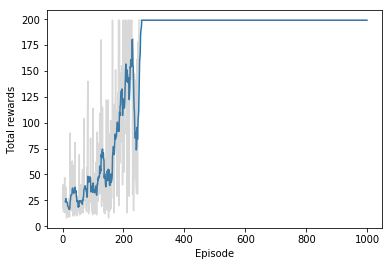

In [41]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Average losses')

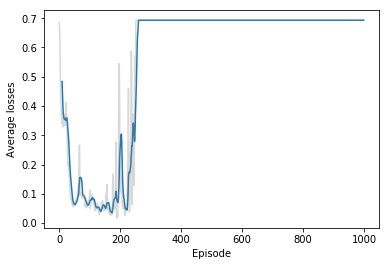

In [42]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

## Testing

Let's checkout how our trained agent plays the game.

In [26]:
import gym

# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

test_episodes = 1
test_max_steps = 20000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

with tf.Session() as sess:

    # Initialize/restore/load the trained model 
    #sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # iterations
    for ep in range(test_episodes):

        # Start a new episode/epoch
        env.reset()
        
        # number of env/rob steps
        for _ in range(test_max_steps):
            
            # Rendering the env graphics
            env.render()
            
            # Batch from the OLD memory
            batch = memory.buffer
            #actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            #rewards = np.array([each[2] for each in batch])
            
            # Calculating next action using OLD memory
            actions_logits = sess.run(model.actions_logits, feed_dict={model.states: states})
            last_action_logits = actions_logits[-1]
            
            # Take action, get new state and reward
            #action = env.action_space.sample()
            action = np.argmax(last_action_logits)
            state, _, done, _ = env.step(action)
            reward = 1 - float(done)
            
            # New memory (time direction)
            memory.buffer.append((action, state, reward))
            
            # The task is done or not;
            if done:
                break
                
# Closing the env
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.